# Visualizing Conv filters using ActivationMaximization

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/keisen/tf-keras-vis/blob/master/examples/visualize_conv_filters.ipynb)
[![Right click and save](https://img.shields.io/badge/Notebook-Open_In_Github-orange.svg)](https://github.com/keisen/tf-keras-vis/blob/master/docs/examples/visualize_conv_filters.ipynb)

Preparation
-----------

### Load libraries

In [1]:
%load_ext autoreload
%autoreload 2
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

%matplotlib inline
from packaging.version import parse as version

from tf_keras_vis.utils import num_of_gpus

if version(tf.version.VERSION) < version('2.16.0'):
    import tensorflow.keras as keras
else:
    import keras

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 0 GPUs


### Load keras.Model

In this notebook, we use VGG16 model, however if you want to use other keras.Model, you can do so by modifying the section below.

In [2]:
model = keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)
model.summary()

2025-03-11 10:11:23.089008: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2025-03-11 10:11:23.127872: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1497600000 Hz
2025-03-11 10:11:23.159298: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55d6cccfa300 executing computations on platform Host. Devices:
2025-03-11 10:11:23.159360: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
2025-03-11 10:11:24.562677: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 411041792 exceeds 10% of system memory.
2025-03-11 10:11:25.600036: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 411041792 exceeds 10% of system memory.
2025-03-11 10:11:25.968289: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 411041792 exceeds 10% of system memory.
2025-03-11 

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Implement functions required to use ActivationMaximization
----------------------------------------------------------

### Model modifier

You **MUST** define a model modifier to replace the model output to target layer's output that has filters you want to visualize, and , in addion, replace the function of it to a linear activation function.

Although we create and use `ExtractIntermediateLayer` and `ReplaceToLinear` instance, we can also use the model modifier function defined by ourselves.

In [3]:
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear

layer_name = 'block5_conv3'  # The target layer that is the last layer of VGG16.

# This instance constructs new model whose output is replaced to `block5_conv3` layer's output.
extract_intermediate_layer = ExtractIntermediateLayer(index_or_name=layer_name)
# This instance modify the model's last activation function to linear one.
replace2linear = ReplaceToLinear()


# Instead of using ExtractIntermediateLayer and ReplaceToLinear instance,
# you can also define the function from scratch as follows:
def model_modifier_function(current_model):
    target_layer = current_model.get_layer(name=layer_name)
    target_layer.activation = keras.activations.linear
    new_model = keras.Model(inputs=current_model.inputs, outputs=target_layer.output)
    return new_model

### Score function

And then, you **MUST** create `Score` instance or define `score function` that returns target scores. Here, they return the value of 3rd filter in `block5_conv3` layer. 

In [4]:
from tf_keras_vis.utils.scores import CategoricalScore

filter_number = 3
score = CategoricalScore(filter_number)


# Instead of using CategoricalScore object above,
# you can also define the function from scratch as follows:
def score_function(output):
    return output[..., filter_number]

Visualizeing a conv filter
--------------------------

### Create ActivationMaximization Instnace

When `clone` argument is True(default), the `model` will be cloned, so the `model` instance will be NOT modified, however the process may take a while.

Here, because the ExtractIntermediateLayer instance will construct new model, setting `False`.

In [5]:
from tf_keras_vis.activation_maximization import ActivationMaximization

activation_maximization = ActivationMaximization(
    model,
    # Please note that `extract_intermediate_layer` has to come before `replace2linear`.
    model_modifier=[extract_intermediate_layer, replace2linear],
    clone=False)

### Visualize
ActivationMaximization will maximize the value computed by the score function. Here, we will visualize the 63rd convolutional filter.

1/1 [==============================] - 5s 5s/step - Score: -26.6444 - TotalVariation2D: 91.6567 - Norm: 38.1966


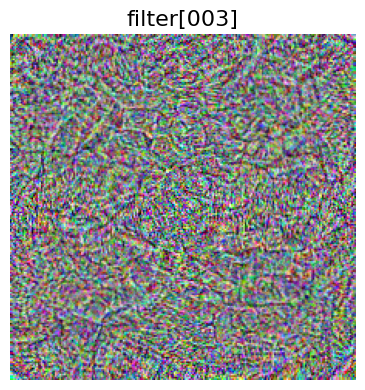

CPU times: user 8.27 s, sys: 1.61 s, total: 9.88 s
Wall time: 5.59 s


In [6]:
%%time

from tf_keras_vis.activation_maximization.callbacks import Progress

# Generate maximized activation
activations = activation_maximization(score, callbacks=[Progress()])
activations = activations.astype(np.uint8)

# Render
f, ax = plt.subplots(figsize=(4, 4))
ax.imshow(activations[0])
ax.set_title('filter[{:03d}]'.format(filter_number), fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

Visualizing Conv filters
------------------------

Then, let's visualize multiple convolutional filters!


### Modify Score function

Because change the target you want to visualize, you MUST create `Score` instance or define `score function` again. Here, our socre function returns the values corresponding to 63rd, 132nd and 320th filters of the layer.

In [7]:
from tf_keras_vis.utils.scores import CategoricalScore

filter_numbers = [63, 132, 320]
scores = CategoricalScore(filter_numbers)

### Create Seed-Input values

And then, you MUST create `seed_input` value. In default, when visualizing a specific filter, tf-keras-vis automatically generates `seed_input` to visualize a image. When visualizing multiple images, you MUST manually create `seed_input`.

In [8]:
# Define seed inputs whose shape is (samples, height, width, channels).

seed_input = tf.random.uniform((3, 224, 224, 3), 0, 255)

### Visualize

In [9]:
%%time

from tf_keras_vis.activation_maximization.callbacks import Progress

# Generate maximized activation
activations = activation_maximization(scores, seed_input=seed_input, callbacks=[Progress()])
activations = activations.astype(np.uint8)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, filter_number in enumerate(filter_numbers):
    ax[i].set_title('filter[{:03d}]'.format(filter_number), fontsize=16)
    ax[i].imshow(activations[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

 14/200 [=>............................] - ETA: 28:42 - Score: 181.4960 - TotalVariation2D: 53.8528 - Norm: 37.8567

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/keisen/.pyenv/versions/tkv37/lib/python3.7/site-packages/IPython/core/magics/execution.py", line 1335, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 4, in <module>
  File "/home/keisen/tf-keras-vis/tf_keras_vis/activation_maximization/__init__.py", line 235, in __call__
    unconnected_gradients=unconnected_gradients)
  File "/home/keisen/.pyenv/versions/tkv37/lib/python3.7/site-packages/tensorflow_core/python/eager/backprop.py", line 1014, in gradient
    unconnected_gradients=unconnected_gradients)
  File "/home/keisen/.pyenv/versions/tkv37/lib/python3.7/site-packages/tensorflow_core/python/eager/imperative_grad.py", line 76, in imperative_grad
    compat.as_str(unconnected_gradients.value))
  File "/home/keisen/.pyenv/versions/tkv37/lib/python3.7/site-packages/tensorflow_core/python/eager/backprop.py", line 138, in _gradient_function
    return grad_fn(mock_op, *out_grads)
  File "/home/keisen/.pyenv/versions/tkv3

TypeError: object of type 'NoneType' has no len()